In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import numpy as np
from rdkit.Chem import Draw
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import precision_recall_curve
import seaborn as sns; sns.set()

RDKit WARNING: [13:58:32] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
data = pd.read_csv('/home/valeriia/bakalarka/bakalarka/LXRb_ch25_curated_DW_2.csv')
# copy raw data
data_new = data.copy()
data_new["Molecule"] = [Chem.MolFromSmiles(mol) for mol in data["smiles"]]

#colmun['Molecule'] invert to binary systems
data_new['bin'] = [np.array(AllChem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in data_new['Molecule']]


In [3]:
data[:5]

smiles      chembl_id   potency  \
0   Cc1cc2c(cc1C(=C)c3ccc(cc3)C(=O)O)C(C)(C)CCC2(C)C     CHEMBL1023   434.000   
1  CCc1nc2c(cccc2nc1c3ccc(cc3)c4cccc(c4)S(=O)(=O)...  CHEMBL1089232  2805.000   
2  CS(=O)(=O)c1cccc(c1)c2ccc(CN(Cc3ccc(F)cc3Cl)S(...  CHEMBL1091034     3.162   
3  Cc1ccccc1S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O)...  CHEMBL1091976     3.162   
4  Cn1cnc(c1)S(=O)(=O)N(Cc2ccc(cc2)c3cccc(c3)S(=O...  CHEMBL1092952    79.430   

      pec50  category  
0  6.362510    active  
1  5.569777  inactive  
2  8.500038    active  
3  8.500038    active  
4  7.100015    active

In [4]:
data_new.pec50.min()

3.9023956711255896

In [5]:
data_new.pec50.max()

9.0

Confusion_matrix for test set:
[[231  32]
 [  0   7]]


            predicted+  predicted-
0  actual+           7          32
1  actual-           0         231


Accuracy: 0.8814814814814815


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       231
           1       1.00      0.18      0.30        39

    accuracy                           0.88       270
   macro avg       0.94      0.59      0.62       270
weighted avg       0.90      0.88      0.84       270

Average absolute error: 0.12 degrees.
Sensitivity: 1.0
Specifity: 0.878
MMC: 0.397
Positive predictive 0.179
Negative predictive 1.0
False positive 0.122
False negative 0.0
False discovery 0.821
Overall accuracy 0.881
roc_auc_score for RandomForestClassification:  0.9154


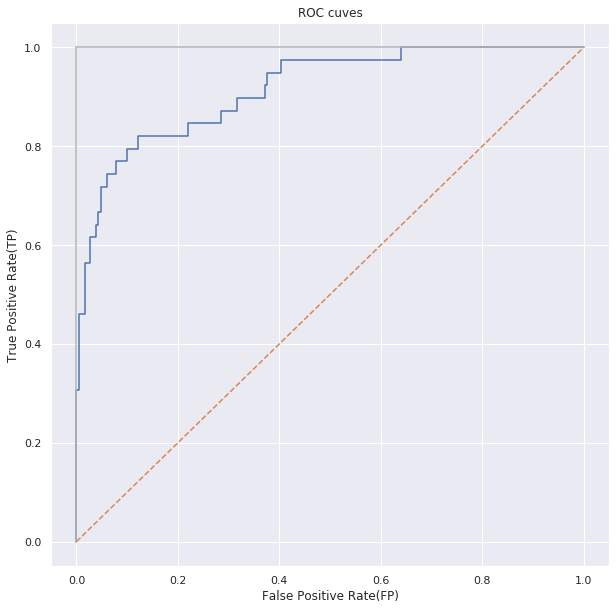

0.8814814814814815

In [119]:
##### classifikation model change thre and than i compare date for diferent thre
#this model predict active/inactive compounds
random_state = 20
thre = 7

#add new columns, number of columns
data_new['number'] = data_new['chembl_id'].rank(method='min')
lab_enc = preprocessing.LabelEncoder()
data_new['number']= lab_enc.fit_transform(data_new['number'])
data_new['category_new'] = np.where(data_new['pec50']>=thre, 1, 0)

#divided date for two sets: train and test
train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train, test = train.copy(), test.copy()
x_train = np.asarray([x for x in train['bin']])
x_test = np.asarray([x for x in test['bin']]) 
y_train = np.asarray([y for y in train['category_new']])
y_test = np.asarray([y for y in test['category_new']])

#RandomForesrClassifier
crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
crf.fit(x_train,y_train)

# prediction on test set
crf_predict = crf.predict(x_test)

#CLassification:
   #accuracy, spe, sen, MCC,
    #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
#confusion_matrix
print("Confusion_matrix for test set:")
conf_matrix = confusion_matrix(crf.predict(x_test), y_test)
print(conf_matrix)
TN, FP, FN, TP = conf_matrix.ravel()
d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
df = pd.DataFrame(data=d)
print("\n")
print(df)
print("\n")

#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
print("\n")
print("=== Classification Report ===")
print(classification_report(y_test, crf_predict))

# Performance metrics
errors = abs(crf_predict - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity:", round(TPR,3))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specifity:", round(TNR, 3))
#MCC
MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
print("MMC:", round(MCC, 3))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive predictive", round(PPV,3))
# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive", round(NPV,3))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive", round(FPR,3))
# False negative rate
FNR = FN/(TP+FN)
print("False negative", round(FNR,3))
# False discovery rate
FDR = FP/(TP+FP)
print("False discovery", round(FDR,3))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy", round(ACC,3))

#put data for pandas data_out
try:
    da = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
      'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
    dff = pd.DataFrame(data=da)

    data_out = data_out.append(dff, ignore_index = True)
    data_out.drop_duplicates(keep='first', inplace=True)
except:
    daa = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
      'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
    data_out = pd.DataFrame(data=daa)



y_score1 = crf.predict_proba(x_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))

#PLOT ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('ROC cuves')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate(TP)')
plt.xlabel('False Positive Rate(FP)')
plt.show()




#cross-validation
crf.score(x_test, y_test)

In [92]:
data_out.head()

threshold  Accuracy  Sensitiv.   Specif.       MCC  Positive pred  \
0        7.0  0.881481   1.000000  0.878327  0.397050       0.179487   
1        5.0  0.918519   0.923611  0.912698  0.836310       0.923611   
2        5.5  0.870370   0.852713  0.886525  0.740154       0.873016   
3        6.0  0.800000   0.880000  0.781818  0.542414       0.478261   
4        6.5  0.803704   0.923077  0.797665  0.362823       0.187500   

   Negative pred  False positive  False negative  
0       1.000000        0.121673        0.000000  
1       0.912698        0.087302        0.076389  
2       0.868056        0.113475        0.147287  
3       0.966292        0.218182        0.120000  
4       0.995146        0.202335        0.076923

In [97]:
data_out.to_csv('data_out_diferent_threshold_clasification_model.csv', encoding='utf-8')

In [121]:
n_splits = 10
print("crf_score", crf.score(x_test, y_test))
cros_x = np.asarray([x for x in data_new['bin']])
cros_y = np.asarray([y for y in data_new['category_new']])
scores = cross_val_score(crf, cros_x, cros_y, cv=5)
print("Cross_val_scores",scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("\n")

#Cross Validation
print("Cross validation:")
kf = KFold(n_splits = n_splits)
a = -1   
        
for trains, tests in kf.split(cros_x, cros_y):
    a = a+1
    print('Number of split:', a)
    
    print("Accuracy:",metrics.accuracy_score(cros_y[tests], crf.predict(cros_x[tests])))
    crf_predict = crf.predict(cros_x[tests])
    
    conf_matrix = confusion_matrix(crf.predict(cros_x[tests]),
                                   cros_y[tests])
    print(conf_matrix)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    #MCC
    MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    
    #put data for pandas data_out   
    try:
        datt = {'threshold': [thre],'N_Split':[n_splits],'Split':[a],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
            'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
        daf = pd.DataFrame(data=datt)
        
        data_vystup = data_vystup.append(daf, ignore_index = True)
        data_vystup.drop_duplicates(keep='first', inplace=True) 
    except:
       
        daat = {'threshold': [],'N_Split':[], 'Split':[],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
          'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
        data_vystup = pd.DataFrame(data=daat)
        


crf_score 0.8814814814814815
Cross_val_scores [0.88425926 0.88425926 0.89814815 0.87962963 0.875     ]
Accuracy: 0.88 (+/- 0.02)


Cross validation:
Number of split: 0
Accuracy: 0.9166666666666666
[[98  9]
 [ 0  1]]
Number of split: 1
Accuracy: 1.0
[[108]]
Number of split: 2
Accuracy: 1.0
[[108]]
Number of split: 3
Accuracy: 0.9629629629629629
[[104   4]
 [  0   0]]
Number of split: 4
Accuracy: 0.8240740740740741
[[89 19]
 [ 0  0]]
Number of split: 5
Accuracy: 0.9444444444444444
[[102   6]
 [  0   0]]
Number of split: 6
Accuracy: 0.8981481481481481
[[97 11]
 [ 0  0]]
Number of split: 7
Accuracy: 0.7777777777777778
[[76 23]
 [ 1  8]]
Number of split: 8
Accuracy: 0.9166666666666666
[[85  9]
 [ 0 14]]
Number of split: 9
Accuracy: 0.8518518518518519
[[87 16]
 [ 0  5]]


In [123]:
data_vystup.to_csv('vystup_Nsplits5,10_clasification_model.csv', encoding='utf-8')

In [122]:
data_vystup

threshold  N_Split  Split  Accuracy  Sensitiv.   Specif.      MCC  \
0         5.0      5.0    0.0  0.918519   0.923611  0.912698  0.83631   
1         5.0      5.0    1.0  0.918519   0.923611  0.912698  0.83631   
2         5.0      5.0    2.0  0.918519   0.923611  0.912698  0.83631   
3         5.0      5.0    3.0  0.918519   0.923611  0.912698  0.83631   
4         5.0      5.0    4.0  0.918519   0.923611  0.912698  0.83631   
..        ...      ...    ...       ...        ...       ...      ...   
70        7.0     10.0    5.0  0.881481   1.000000  0.878327  0.39705   
71        7.0     10.0    6.0  0.881481   1.000000  0.878327  0.39705   
72        7.0     10.0    7.0  0.881481   1.000000  0.878327  0.39705   
73        7.0     10.0    8.0  0.881481   1.000000  0.878327  0.39705   
74        7.0     10.0    9.0  0.881481   1.000000  0.878327  0.39705   

    Positive pred  Negative pred  False positive  False negative  
0        0.923611       0.912698        0.087302        0.076389  
1        0.923611       0.912698        0.087302        0.076389  
2        0.923611       0.912698        0.087302        0.076389  
3        0.923611       0.912698        0.087302        0.076389  
4        0.923611       0.912698        0.087302        0.076389  
..            ...            ...             ...             ...  
70       0.179487       1.000000        0.121673        0.000000  
71       0.179487       1.000000        0.121673        0.000000  
72       0.179487       1.000000        0.121673        0.000000  
73       0.179487       1.000000        0.121673        0.000000  
74       0.179487       1.000000        0.121673        0.000000  

[75 rows x 11 columns]

Regressor score: 0.7140891324409928


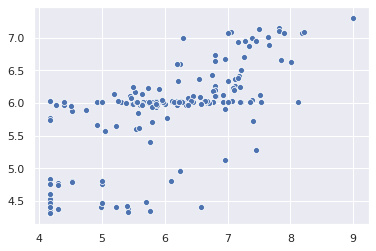

In [54]:
#Regresion model
random_state = 20
train_reg, test_reg = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train_reg, test_reg = train.copy(), test.copy()

data_new_reg = [i for i in data_new['bin']]

x_train_reg = [f for f in train_reg['bin']]
x_test_reg = [f for f in test_reg['bin']]
y_train_reg = [a for a in train_reg['pec50']]
y_test_reg = [a for a in test_reg['pec50']]

rfr = RandomForestRegressor(n_estimators=101,max_depth=4, random_state=random_state)
rfr.fit(x_train_reg, y_train_reg)

y_pred = rfr.predict(x_test_reg)
sns.scatterplot(x=y_test_reg, y=y_pred)


print("Regressor score:", rfr.score(x_test_reg, y_test_reg))

y_pred = rfr.predict(data_new_reg)
data_new['pec50_new'] = y_pred




In [78]:
#create classification model after reggresion model
random_state = 20
thre = 7

#add new column
data_new['category_new_reg'] = np.where(data_new['pec50_new']>=thre, 1, 0)
 

#divided date for two sets: train and test
train, test = train_test_split(data_new, test_size = 0.25, random_state = random_state)
train, test = train.copy(), test.copy()
x_train = np.asarray([x for x in train['bin']])
x_test = np.asarray([x for x in test['bin']]) 
y_train = np.asarray([y for y in train['category_new_reg']])
y_test = np.asarray([y for y in test['category_new_reg']])

#RandomForesrClassifier
crf = RandomForestClassifier(n_estimators=101, max_depth=4, random_state=random_state)
crf.fit(x_train,y_train)

# prediction on test set
crf_predict = crf.predict(x_test)

#CLassification:
   #accuracy, spe, sen, MCC,
    #confusion matrices (true positive, true negative, false positive, false negative (TP, TN, FP, FN))
    
#confusion_matrix
print("Confusion_matrix for test set:")
conf_matrix = confusion_matrix(crf.predict(x_test), y_test)
print(conf_matrix)
TN, FP, FN, TP = conf_matrix.ravel()
d = {' ': ['actual+', 'actual-'], 'predicted+':[TP, FN], 'predicted-':[FP, TN]}
df = pd.DataFrame(data=d)
print("\n")
print(df)
print("\n")

#Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, crf.predict(x_test)))
print("\n")
print("=== Classification Report ===")
print(classification_report(y_test, crf_predict))

# Performance metrics
errors = abs(crf_predict - y_test)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity:", round(TPR,3))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specifity:", round(TNR, 3))
#MCC
MCC = ((TP*TN)-(FP*FN))/((TP+FP)*(FN+TN)*(FP+TN)*(TP+FN))**(1/2)
print("MMC:", round(MCC, 3))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Positive predictive", round(PPV,3))
# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive", round(NPV,3))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False positive", round(FPR,3))
# False negative rate
FNR = FN/(TP+FN)
print("False negative", round(FNR,3))
# False discovery rate
FDR = FP/(TP+FP)
print("False discovery", round(FDR,3))
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy", round(ACC,3))

#put data for pandas data_out
try:
    dda = {'threshold': [thre],'Accuracy':[ACC], 'Sensitiv.':[TPR], 'Specif.':[TNR], 'MCC':[MCC],
      'Positive pred':[PPV], 'Negative pred':[NPV], 'False positive':[FPR], 'False negative':[FNR]}
    ddff = pd.DataFrame(data=dda)

    data_out_reg = data_out_reg.append(ddff, ignore_index = True)
    data_out_reg.drop_duplicates(keep='first', inplace=True)
except:
    ddaa = {'threshold': [],'Accuracy':[], 'Sensitiv.':[], 'Specif.':[], 'MCC':[],
      'Positive pred':[], 'Negative pred':[], 'False positive':[], 'False negative':[]}
    data_out_reg = pd.DataFrame(data=ddaa)



y_score1 = crf.predict_proba(x_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score for RandomForestClassification: ', round(roc_auc_score(y_test, y_score1),4))


Confusion_matrix for test set:
[[259   3]
 [  1   7]]


            predicted+  predicted-
0  actual+           7           3
1  actual-           1         259


Accuracy: 0.9851851851851852


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       260
           1       0.88      0.70      0.78        10

    accuracy                           0.99       270
   macro avg       0.93      0.85      0.89       270
weighted avg       0.98      0.99      0.98       270

Average absolute error: 0.01 degrees.
Sensitivity: 0.875
Specifity: 0.989
MMC: 0.775
Positive predictive 0.7
Negative predictive 0.996
False positive 0.011
False negative 0.125
False discovery 0.3
Overall accuracy 0.985
roc_auc_score for RandomForestClassification:  0.9985


In [76]:
data_out_reg.head()

threshold  Accuracy  Sensitiv.   Specif.       MCC  Positive pred  \
0        5.5  0.966667   0.992754  0.939394  0.934485       0.944828   
1        5.0  0.970370   0.986111  0.952381  0.940776       0.959459   
2        6.0  0.870370   0.939759  0.839572  0.734028       0.722222   
3        6.5  0.955556   1.000000  0.953125  0.716395       0.538462   
4        7.0  0.985185   0.875000  0.988550  0.775347       0.700000   

   Negative pred  False positive  False negative  
0       0.992000        0.060606        0.007246  
1       0.983607        0.047619        0.013889  
2       0.969136        0.160428        0.060241  
3       1.000000        0.046875        0.000000  
4       0.996154        0.011450        0.125000

In [100]:
data_out_reg.to_csv('data_out_reg_diferentthreshold_clasification_modelafter_reg.csv',  encoding='utf-8')

In [6]:
data_clas = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_diferent_threshold_clasification_model.csv')


In [7]:
print("Data for classifikation model(step 1)")
data_clas.head()


Data for classifikation model(step 1)


Unnamed: 0  threshold  Accuracy  Sensitiv.   Specif.       MCC  \
0           0        7.0  0.881481   1.000000  0.878327  0.397050   
1           1        5.0  0.918519   0.923611  0.912698  0.836310   
2           2        5.5  0.870370   0.852713  0.886525  0.740154   
3           3        6.0  0.800000   0.880000  0.781818  0.542414   
4           4        6.5  0.803704   0.923077  0.797665  0.362823   

   Positive pred  Negative pred  False positive  False negative  
0       0.179487       1.000000        0.121673        0.000000  
1       0.923611       0.912698        0.087302        0.076389  
2       0.873016       0.868056        0.113475        0.147287  
3       0.478261       0.966292        0.218182        0.120000  
4       0.187500       0.995146        0.202335        0.076923

In [5]:
data_clas_cros = pd.read_csv('/home/valeriia/bakalarka/bakalarka/vystup_Nsplits5,10_clasification_model.csv')
print("Data after croos validation for classification model (step1)")
data_clas_cros

Data after croos validation for classification model (step1)


Unnamed: 0  threshold  N_Split  Split  Accuracy  Sensitiv.   Specif.  \
0            0        5.0      5.0    0.0  0.918519   0.923611  0.912698   
1            1        5.0      5.0    1.0  0.918519   0.923611  0.912698   
2            2        5.0      5.0    2.0  0.918519   0.923611  0.912698   
3            3        5.0      5.0    3.0  0.918519   0.923611  0.912698   
4            4        5.0      5.0    4.0  0.918519   0.923611  0.912698   
..         ...        ...      ...    ...       ...        ...       ...   
70          70        7.0     10.0    5.0  0.881481   1.000000  0.878327   
71          71        7.0     10.0    6.0  0.881481   1.000000  0.878327   
72          72        7.0     10.0    7.0  0.881481   1.000000  0.878327   
73          73        7.0     10.0    8.0  0.881481   1.000000  0.878327   
74          74        7.0     10.0    9.0  0.881481   1.000000  0.878327   

        MCC  Positive pred  Negative pred  False positive  False negative  
0   0.83631       0.923611       0.912698        0.087302        0.076389  
1   0.83631       0.923611       0.912698        0.087302        0.076389  
2   0.83631       0.923611       0.912698        0.087302        0.076389  
3   0.83631       0.923611       0.912698        0.087302        0.076389  
4   0.83631       0.923611       0.912698        0.087302        0.076389  
..      ...            ...            ...             ...             ...  
70  0.39705       0.179487       1.000000        0.121673        0.000000  
71  0.39705       0.179487       1.000000        0.121673        0.000000  
72  0.39705       0.179487       1.000000        0.121673        0.000000  
73  0.39705       0.179487       1.000000        0.121673        0.000000  
74  0.39705       0.179487       1.000000        0.121673        0.000000  

[75 rows x 12 columns]

In [4]:
data_clas_reg = pd.read_csv('/home/valeriia/bakalarka/bakalarka/data_out_reg_diferentthreshold_clasification_modelafter_reg.csv')
print("Data classifikation(which i built after regresion model)(step 2)")
data_clas_reg

Data classifikation(which i built after regresion model)(step 2)


Unnamed: 0  threshold  Accuracy  Sensitiv.   Specif.       MCC  \
0           0        5.5  0.966667   0.992754  0.939394  0.934485   
1           1        5.0  0.970370   0.986111  0.952381  0.940776   
2           2        6.0  0.870370   0.939759  0.839572  0.734028   
3           3        6.5  0.955556   1.000000  0.953125  0.716395   
4           4        7.0  0.985185   0.875000  0.988550  0.775347   

   Positive pred  Negative pred  False positive  False negative  
0       0.944828       0.992000        0.060606        0.007246  
1       0.959459       0.983607        0.047619        0.013889  
2       0.722222       0.969136        0.160428        0.060241  
3       0.538462       1.000000        0.046875        0.000000  
4       0.700000       0.996154        0.011450        0.125000